# Adaline
This notebook contains the implementation for a practical exercise on adaline studies found on an [Artificial Neural Network book](https://www.amazon.com.br/Neurais-Artificiais-Engenharia-Ci%C3%AAncias-Aplicadas/dp/8588098539). After a brief explanation of how the model works, a training algorithm is implemented and evaluated on a given dataset.  

## The Adaline Model

An adaline model is quite similar to a perceptron model using a single neuron. An illustration of the former model is shown in the following picture.

<img src="Figures/adaline.png">

If you understand the perceptron model, feel free to jump ahead for the **Training Algorithm** subsection.

As encountered on a perceptron, it consists of a single neuron with adjustable sinaptic weights and bias. Let $x \in R^{m+1}$ be an extended version of an input signal $x_i \in R^{m}$ by adding a fixed input $x_0 = +1$ (for practical implementations). Conversely, let $w \in R^{m+1}$ be an extension of a randomly initialized weight vector $w_i \in R^m$ by adding a bias element $b$. 

In this case, a signal $u$ is set as the following equation: 

$\begin{equation}    
    u = \sum_{k = 1}^m x_k \cdot w_k - b = w_i^T \cdot x_i - b = w^T \cdot x
\end{equation}
$

#### Activation Function

In this model, the $u$ signal goes through an activation function $\sigma(\cdot)$ which has several sorts of flavours: 

| Activation Type | Equation | 
| ----------------- | -------------------------| 
| linear $\sigma(x)$ | $\sigma(x) = x$ | 
| unipolar step (hard limiter) | $\sigma(x) = \left\{ \begin{array}{ll} 1  & \mbox{if } x \geq 0 \\ 0 & \mbox{if } x < 0 \end{array}\right.$ |  
| bipolar step | $\sigma(x) = \left\{\begin{array}{ll} 1  & \mbox{if } x \geq 0 \\ -1 & \mbox{if } x < 0 \end{array} \right.$ | 
| logistic | $\sigma(x, \beta) = \frac{1}{1+e^{-\beta x}}$ | 
| tanh | $\sigma(x, \beta) = \frac{1-e^{-\beta x}}{1+e^{-\beta x}}$ | 
| relu | $\sigma(x) = \left\{\begin{array}{ll} x  & \mbox{if } x \geq 0 \\ 0 & \mbox{if } x < 0 \end{array} \right.$ |

The logistic and tanh activation functions are said to be in the sigmoid group and they are largely used on regression problems. For classification, the unipolar or bipolar steps are usually applied given their output are finite integers, which can be mapped to classes. 

It is essential to be aware that, since an activation function has an dinamyc range of operation, both the input and output signals should be preprocessed in a way to also limit its range within that of the activation function's. For example, by using the bipolar step, the input signal should range between $-1$ and $+1$. 

#### Setting the output

Once an activation function is set, the output signal $y$ is defined as 

$y = \sigma(u)$

The single-neuron perceptron model is characterized by identifying linearly separable classes because, by using a bipolar step activation function, the classes are predicted by the following equation.


$y = \left\{
        \begin{array}{ll}
            +1  & \mbox{if } u = w_i^Tx_i - b \geq 0\\
            -1 & \mbox{if } u = w_i^Tx_i - b < 0
    \end{array}
    \right.
$

Therefore, by training an adaline model, we are defining a hyperplan defined by $w_i^Tx_i - b = 0$ which separates both classes on $R^m$. 

#### Training algorithm

Different from a perceptron, an adaline has its training algorithm modified to minimize a cost function based on the mean squared error of the target value and the obtained output. The weight vector is to be updated according to the **Delta Rule** (or **Widrow-Hoff Learning Rule** or **Least Mean Square - LMS** or **Gradient Descent**), which tries to adapt such vector in the opposite direction of a descent gradient given by the aforementioned mean absolute error.  

Formally, considering a optimal weight configuration, we have: 

$Cost(w^*) \leq Cost(w), w \in R^{n+1}$

Usually, the cost function is the mean squared error (MSE) given by 

$MSE = \frac{1}{2}\sum_{k=1}^{N}(y_k - u_k)$

where $y$ is the true output and $u$ is the inputs activation potential. 

In order to present a training algorithm, this notebook uses a dataset extracted from the aforementioned [Artificial Neural Network book](https://www.amazon.com.br/Neurais-Artificiais-Engenharia-Ci%C3%AAncias-Aplicadas/dp/8588098539) which is stored in the *./Datasets* folder. 

The training set contains information of 5 numerical features and 1 target value of 2 classes {P1 and P2}, denoted by [-1, 1] respectively. The test set contains only the features of another set of data.





## Imports

In [54]:
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

## Loading Dataset

In [46]:
df_train = pd.read_csv('./Datasets/ex4_6_train.tsv', sep='\t')
df_train.drop(['sample'], axis=1, inplace=True)
df_test = pd.read_csv('./Datasets/ex4_6_test.tsv', sep='\t')
df_test.drop(['sample'], axis=1, inplace=True)
print ("Train set shape: {}\nTest set shape: {}".format(df_train.shape, df_test.shape))
df_train.head()

Train set shape: (35, 5)
Test set shape: (15, 4)


,x1,x2,x3,x4,target
0,0.4329,-1.3719,0.7022,-0.8535,1.0
1,0.3024,0.2286,0.8630,2.7909,-1.0
2,0.1349,-0.6445,1.0530,0.5687,-1.0
3,0.3374,-1.7163,0.3670,-0.6283,-1.0
4,1.1434,-0.0485,0.6637,1.2606,1.0


In [48]:
df_test.head()

,x1,x2,x3,x4
0,0.9694,0.6909,0.4334,3.4965
1,0.5427,1.3832,0.6390,4.0352
2,0.6081,-0.9196,0.5925,0.1016
3,-0.1618,0.4694,0.2030,3.0117
4,0.1870,-0.2578,0.6124,1.7749


In [49]:
x_train, y_train = df_train.drop(['target'], axis=1).values, df_train['target'].values
x_test = df_test.values

## Creating Perceptron Class

In [82]:
class Adaline:
    def __init__(self, activation = 'tanh', learning_rate = 0.0025, seed = None, beta = None): 
        self.activation = activation
        self.learning_rate = learning_rate
        self.seed = seed
        self.x = None        
        self.x_pred = None
        self.target = None
        self.w = None        
        self.beta = beta
        self.g = self.get_activation(self.activation, self.beta)
        self.mse = None        
        
    def get_activation(self, activation, beta = None):
        """Returns an activation function
            :param activation (str): the name of the function 
                ['linear', 'unipolar_step', 'bipolar_step', 
                'logistic', 'simmetric_ramp', 'tanh', 'relu']
            :return (lambda function): the implemented activation function
        """
        if activation == 'linear':
            g = lambda x: x
        elif activation == 'unipolar_step':
            g = lambda x: 1 if x >= 0 else 0
        elif activation == 'bipolar_step':
            g = lambda x: 1 if x >= 0 else -1
        elif activation == 'logistic':
            g = lambda x, beta: 1/(1 + np.exp(-beta*x))
        elif activation == 'simmetric_ramp':
            g = lambda x, beta: x if x > -beta or x < beta else beta
        elif activation == 'tanh':
            g = lambda x, beta: (1 - np.exp(-beta*x))/(1 + np.exp(-beta*x))
        elif activation == 'relu':
            g = lambda x: x if x > 0 else 0
        else:
            raise NotImplemented
        return g
        
    def mean_squared_error(self):
        p = self.x.shape[0]
        mse = 0
        for k, sample in enumerate(self.x):            
            u = np.dot(sample, self.w)            
            mse += (self.target[k]-u)**2
        return mse/p
        
    def train(self, features, target, epsilon = 1e-6, max_epochs = 2000):
        """ Trains a single neuron adaline model with delta rule training.
            :param features (np.array): an array containg training examples and its features
            :param target (np.array): the true values of the output 
            :param max_epochs: the maximum number of epochs allowed in training
            :epsilon (float): the minimum error to consider a training convergence
        """
        # Appending a bias constant to the features array
        self.x = np.array([np.concatenate(([1], i)) for i in features])
        
        # Initializing the weights with a random uniform function (0, 1)
        self.w = np.array([random.uniform(0,1) for i in np.arange(self.x.shape[1]-1)])
        self.w = np.concatenate(([-1], self.w))
        
        self.mse = list()
        self.target = target        
        epoch = 1
        print ("Epoch {} >> W = {}\tdelta_eps = {}".format(epoch, self.w, self.mean_squared_error()))
        
        # Starting training until max_epochs is reached or no error is found
        keep_training = True
        while (keep_training):                      
            mse_before = self.mean_squared_error()
            self.mse.append(mse_before)
            
            for k, sample in enumerate(self.x):
                u = np.dot(sample, self.w)
                self.w = self.w + self.learning_rate*(target[k]-u)*sample                
            epoch += 1       
            delta_mse = abs(self.mean_squared_error() - mse_before)
            
            if delta_mse <= epsilon:                
                keep_training = False
            
        print ("Epoch {} >> W = {}\tdelta_eps = {}".format(epoch, self.w, delta_mse))
        
    def predict(self, features):
        """ Predicts the output of a set of test features from a pre-trained model
            :params features (np.array): the test set of features
            :return y_pred (np.array): the predicted output
        """
        self.x_pred = np.array([np.concatenate(([1], i)) for i in features])
        u = np.dot(self.x_pred,self.w)
        self.y_pred = list()
        for u_i in u:
            self.y_pred.append(self.g(u_i))
        self.y_pred = np.array(self.y_pred)
        return self.y_pred
        
ada = Adaline(activation='bipolar_step')        
ada.train(features=x_train, target=y_train, epsilon=0.000001)   

Epoch 1 >> W = [-1.          0.52046366  0.68204256  0.63121831  0.0913342 ]	delta_eps = 2.1327567673975025
Epoch 925 >> W = [ 1.81300632  1.31291529  1.64233027 -0.42751014 -1.17778856]	delta_eps = 9.998820008627618e-07



### Starting training  1
Epoch 1 >> W = [-1.          0.62056678  0.5992632   0.88455843  0.57657206]	delta_eps = 4.890354635732102
Epoch 943 >> W = [ 1.81316059  1.31295166  1.6424221  -0.427598   -1.17785228]	delta_eps = 9.904413866279604e-07
Predictions:  [-1 -1  1 -1 -1  1  1  1  1 -1 -1  1 -1 -1  1]

### Starting training  2
Epoch 1 >> W = [-1.          0.58763563  0.91094704  0.89909944  0.83252561]	delta_eps = 9.164547729912105
Epoch 940 >> W = [ 1.81301854  1.31293424  1.64235773 -0.42748518 -1.17780528]	delta_eps = 9.99008725632855e-07
Predictions:  [-1 -1  1 -1 -1  1  1  1  1 -1 -1  1 -1 -1  1]

### Starting training  3
Epoch 1 >> W = [-1.          0.73880759  0.66722097  0.64948163  0.83858806]	delta_eps = 7.975813554061713
Epoch 937 >> W = [ 1.81305865  1.31291878  1.64235031 -0.42755751 -1.17780376]	delta_eps = 9.96744751347034e-07
Predictions:  [-1 -1  1 -1 -1  1  1  1  1 -1 -1  1 -1 -1  1]

### Starting training  4
Epoch 1 >> W = [-1.          0.05804663  0.3381443   0.

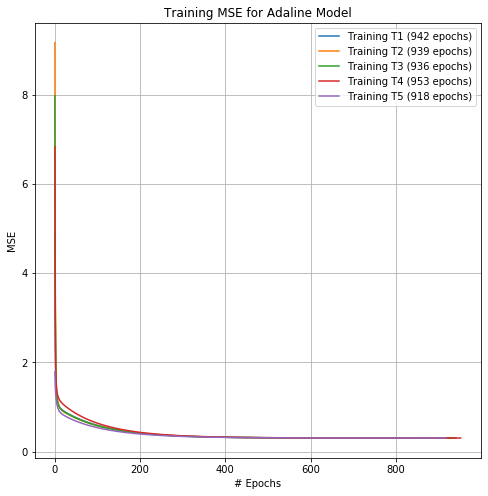

In [83]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title('Training MSE for Adaline Model')
ax.grid(True)
ax.set_ylabel('MSE')
ax.set_xlabel('# Epochs')

for training_index in np.arange(1, 6, 1):
    print ("\n### Starting training ", training_index)
    ada = Adaline(activation='bipolar_step', learning_rate = 0.0025)        
    ada.train(features=x_train, target=y_train, max_epochs=2000, epsilon=1e-6)      
    ax.plot(ada.mse, label = 'Training T{} ({} epochs)'.format(training_index, len(ada.mse)))
    print ("Predictions: ", ada.predict(x_test))
ax.legend()    

After training and prediction 5 times the algorithms on the given train and test set, we can see that, for each round, the output is the **same**, different from the encountered on a previously notebook for the Perceptron model. This is due to the fact that, despite the weights being initialized randomly, the delta rule only converges on the region next to the optimal solution. On a perceptron model, on the otherhand, any solution that would satisfy the Hebbs rule would be accepted, generating a more different set of final weights. 

For this characteristic of the adaline model to provide a solution next to the optimal, it is considered to be more robust to noisy data. However, a greater number of epochs are necessary for the algorithm to converge. 

Given that the algorithm did converge, we can conclude that the input data was linearly separable. 

_______________